In [195]:
import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import date, datetime

import yfinance as yf
from Historic_Crypto import HistoricalData
from scripts.params import COIN_API



# Fear and Greed Index API

Free API that provides one FNG index per day.

`'time_until_update'` value - present only for the last output 

* API just for Bitcoin - take into account for other coins prediction

 **What this index includes?**
* Volatility = 25%
* Market Momentum/Volume = 25%
* Social Media (twitter & reddit) = 15%
* Surveys (currently posed) = 15%
* Dominance (based on Bitcoin) = 10%
* Trends = 10%

In [65]:
url = 'https://api.alternative.me/fng/'
params = {'limit': 100000,
          'date_format': 'world'
         }
response = requests.get(url, params).json()
response

{'name': 'Fear and Greed Index',
 'data': [{'value': '52',
   'value_classification': 'Neutral',
   'timestamp': '28-01-2023',
   'time_until_update': '-1674820652'},
  {'value': '55', 'value_classification': 'Greed', 'timestamp': '27-01-2023'},
  {'value': '54',
   'value_classification': 'Neutral',
   'timestamp': '26-01-2023'},
  {'value': '51',
   'value_classification': 'Neutral',
   'timestamp': '25-01-2023'},
  {'value': '52',
   'value_classification': 'Neutral',
   'timestamp': '24-01-2023'},
  {'value': '50',
   'value_classification': 'Neutral',
   'timestamp': '23-01-2023'},
  {'value': '53',
   'value_classification': 'Neutral',
   'timestamp': '22-01-2023'},
  {'value': '53',
   'value_classification': 'Neutral',
   'timestamp': '21-01-2023'},
  {'value': '51',
   'value_classification': 'Neutral',
   'timestamp': '20-01-2023'},
  {'value': '45', 'value_classification': 'Fear', 'timestamp': '19-01-2023'},
  {'value': '52',
   'value_classification': 'Neutral',
   'timesta

In [66]:
fng_df = pd.DataFrame(response['data']).drop(columns='time_until_update')
fng_df

,value,value_classification,timestamp
0,52,Neutral,28-01-2023
1,55,Greed,27-01-2023
2,54,Neutral,26-01-2023
3,51,Neutral,25-01-2023
4,52,Neutral,24-01-2023
...,...,...,...
1815,11,Extreme Fear,05-02-2018
1816,24,Extreme Fear,04-02-2018
1817,40,Fear,03-02-2018
1818,15,Extreme Fear,02-02-2018


In [77]:
fng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1820 entries, 2023-01-28 to 2018-02-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   value                 1820 non-null   float64
 1   value_classification  1820 non-null   object 
dtypes: float64(1), object(1)
memory usage: 42.7+ KB


In [67]:
fng_df.timestamp = pd.to_datetime(fng_df.timestamp, format='%d-%m-%Y')
fng_df.set_index('timestamp', inplace=True)

Getting the last datapoint date of fng index and transforming it into string to use it further for rate exchanges requests

In [68]:
# changing the format of the date
fng_first_timestamp = fng_df.index[-1].date().strftime('%Y-%m-%d')
print(f'The first datapoint for fng index is {fng_first_timestamp}')

The first datapoint for fng index is 2018-02-01


In [69]:
# changing the format of the date
fng_last_timestamp = fng_df.index[0].date().strftime('%Y-%m-%d')
print(f'The last datapoint for fng index is {fng_last_timestamp}')

The last datapoint for fng index is 2023-01-28


In [70]:
#changing datatype
fng_df.value = fng_df.value.astype('float')

In [71]:
fng_df.head()

,value,value_classification
timestamp,,
2023-01-28,52.0,Neutral
2023-01-27,55.0,Greed
2023-01-26,54.0,Neutral
2023-01-25,51.0,Neutral
2023-01-24,52.0,Neutral


In [72]:
fng_df.dtypes

value                   float64
value_classification     object
dtype: object

## SHORT EDA

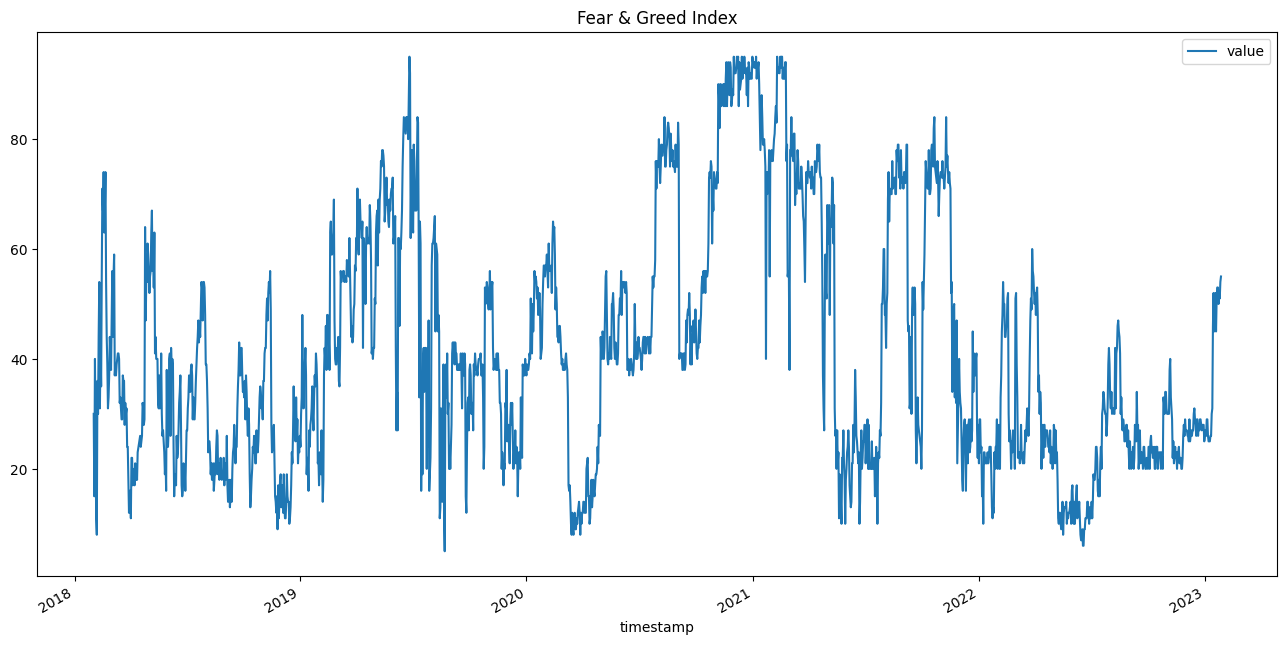

In [11]:
# fluctuation of fear and greed index
fng_df.plot(y='value', use_index=True, figsize=(16,8), title='Fear & Greed Index');

In [73]:
#minimal value 
min_val = fng_df[fng_df.value == fng_df.value.min()]
min_val
print(f"{min_val.value_classification[0]} with fng index of {min_val.value[0]} was measured on the {min_val.index[0].date().strftime('%Y-%m-%d')}.")

Extreme Fear with fng index of 5.0 was measured on the 2019-08-22.


In [74]:
# maximal values
max_val = fng_df[fng_df.value == fng_df.value.max()]
max_val

,value,value_classification
timestamp,,
2021-02-17,95.0,Extreme Greed
2021-02-16,95.0,Extreme Greed
2021-02-14,95.0,Extreme Greed
2021-02-09,95.0,Extreme Greed
2021-01-06,95.0,Extreme Greed
2020-12-31,95.0,Extreme Greed
2020-12-18,95.0,Extreme Greed
2020-12-14,95.0,Extreme Greed
2020-12-08,95.0,Extreme Greed


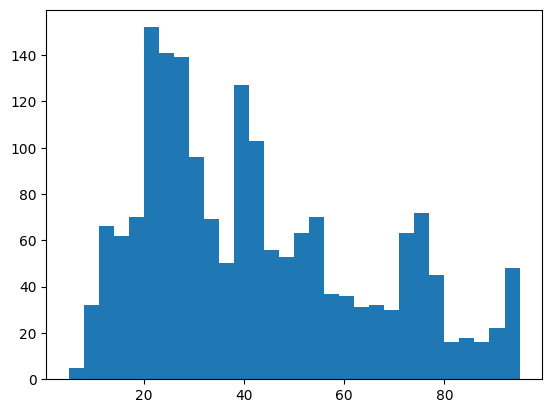

In [103]:
# index distribution 
plt.hist(fng_df.value, bins=30);

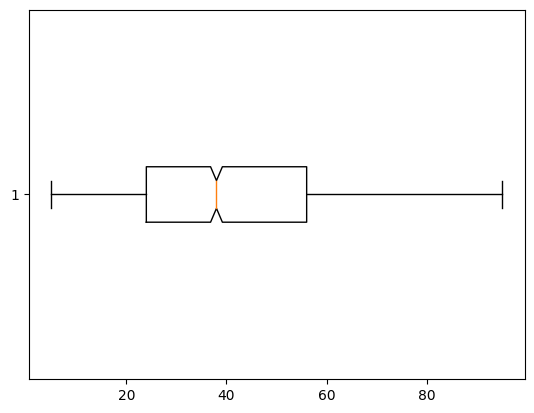

In [110]:
plt.boxplot(fng_df.value, notch=True, vert=False);

In [101]:
print(f"""
          The minimal index : {fng_df.value.min()} \n
          the maximum index : {fng_df.value.max()} \n
          the median index  : {fng_df.value.median()} \n
          the mean index    : {fng_df.value.mean().round()} """)




          The minimal index : 5.0 

          the maximum index : 95.0 

          the median index  : 38.0 

          the mean index    : 42.0 


## Variation of index

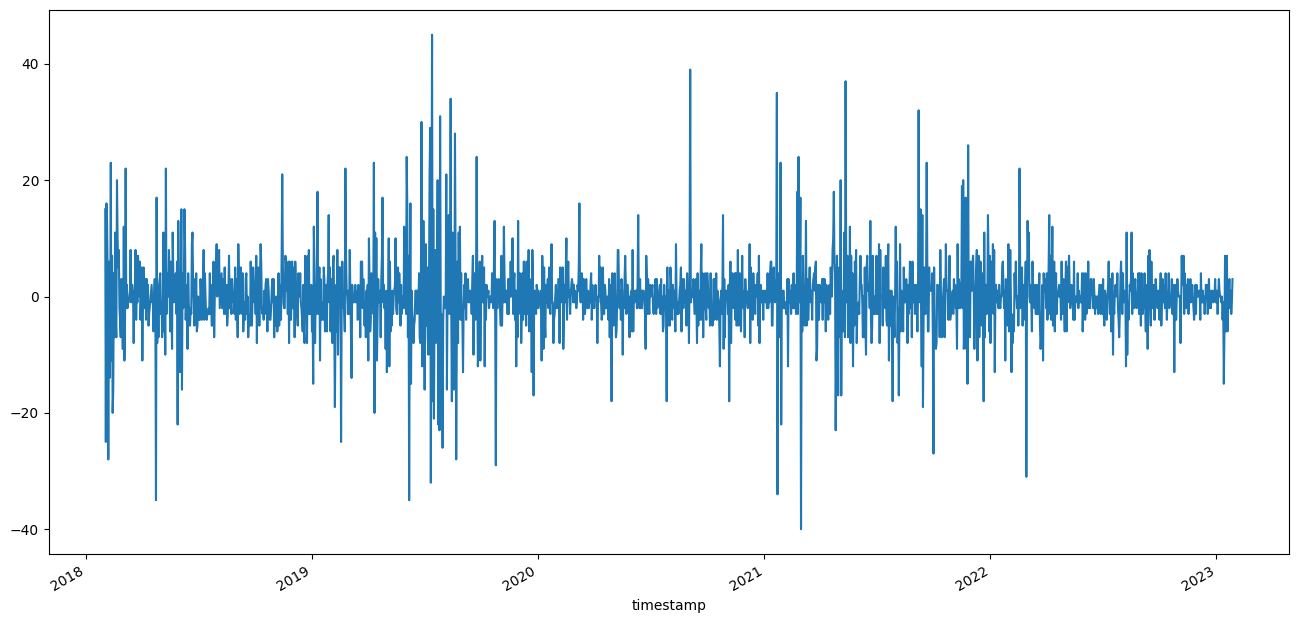

In [123]:
fng_df.value.diff(periods=1).plot(figsize=(16,8));

Variation is quite random.

In [133]:
#fng_var = pd.DataFrame(fng_df.value.diff(periods=1)).dropna().sort_values(by='value')
#fng_var

,value
timestamp,
2021-03-01,-40.0
2018-04-24,-35.0
2019-06-07,-35.0
2021-01-22,-34.0
2019-07-12,-32.0
...,...
2019-08-13,34.0
2021-01-21,35.0
2021-05-12,37.0


Autocorrelation is high and decreases slowly. Which is normal because the changes from day to day are not extreme.

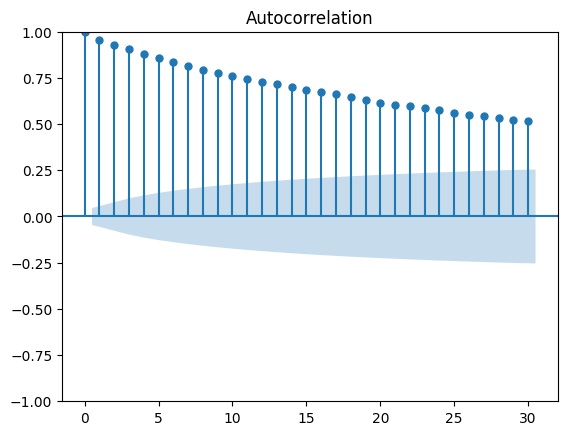

In [116]:
# autocorrealtion
plot_acf(fng_df.value, lags=30);

The partial correlation is strong with d-1 and also d-2. Next days are statistically insignificant because they are within the confidence interval. Maybe an indicator for prediciton timegap.

/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


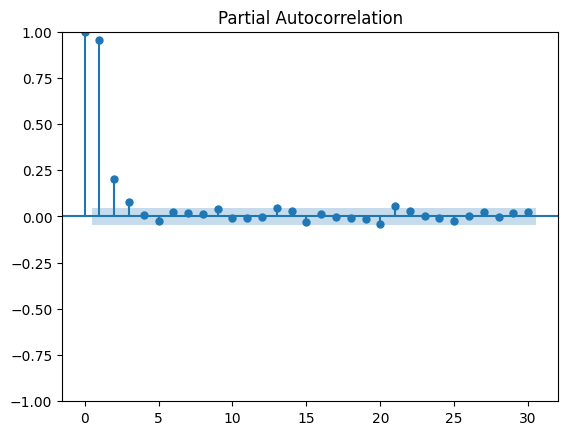

In [134]:
plot_pacf(fng_df.value, lags=30);

## In terms of emotion classes

In [80]:
# the most frequent emotions felt
fng_freq = fng_df.groupby('value_classification').count().sort_values(by='value', ascending=False)
fng_freq

,value
value_classification,
Fear,640
Extreme Fear,528
Greed,305
Extreme Greed,185
Neutral,162


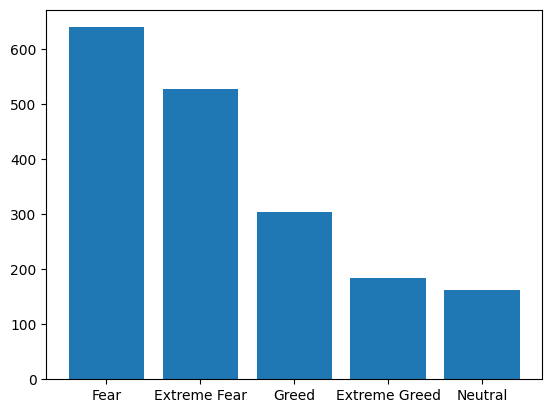

In [94]:
plt.bar(fng_freq.index, fng_freq.value);

In [82]:
print(f"""From {fng_first_timestamp} till {fng_last_timestamp}: \n
      the most frequent emotion was {fng_freq.index[0]} which was measured on {fng_freq.value[0]} days\n
      the least frequent emotion was {fng_freq.index[-1]}  which was measured on {fng_freq.value[-1]} days.""")

From 2018-02-01 till 2023-01-28: 

      the most frequent emotion was Fear which was measured on 640 days

      the least frequent emotion was Neutral  which was measured on 162 days.


# Historical data

Library that provides historical crypto data

**quite slow comparing to api**

In [12]:
dataset = HistoricalData(start_date = '2023-01-01-05-05',
                        ticker = 'BTC-USD',
                        granularity=86400,
                        verbose = False).retrieve_data()
dataset

,low,high,open,close,volume
time,,,,,
2023-01-02,16542.52,16789.99,16611.90,16666.95,13560.460180
2023-01-03,16600.00,16772.30,16666.86,16669.47,17612.355277
2023-01-04,16645.87,16988.00,16668.95,16844.42,25922.706806
2023-01-05,16750.07,16872.13,16844.40,16825.69,14918.229133
2023-01-06,16670.82,17027.11,16825.53,16948.06,24235.387042
2023-01-07,16903.58,16977.76,16948.00,16942.37,5680.117994
2023-01-08,16910.41,17167.52,16942.37,17125.18,9195.459854
2023-01-09,17102.97,17396.25,17125.17,17177.98,33252.154359
2023-01-10,17145.10,17494.37,17177.94,17443.50,24901.574858


# COIN API

can get just 580 datapoint by 1 request

In [13]:
today = date.today()
today = today.strftime('%Y-%m-%d')
today

'2023-01-27'

In [22]:
API_KEY = COIN_API

period_id = '1DAY'
asset_id_base = 'BTC'
asset_id_quote = 'USD'


time = 'T00:00:00'
time_start = f'{fng_first_timestamp}{time}'
time_end = f'{fng_first_timestamp}{time}'

limit=100000


In [24]:
url = f'https://rest.coinapi.io/v1/exchangerate/{asset_id_base}/{asset_id_quote}/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
headers = {'X-CoinAPI-Key' : API_KEY} 
response = requests.get(url, headers=headers).json()
response

[{'time_period_start': '2019-09-01T00:00:00.0000000Z',
  'time_period_end': '2019-09-02T00:00:00.0000000Z',
  'time_open': '2019-09-01T00:01:00.0000000Z',
  'time_close': '2019-09-01T23:59:00.0000000Z',
  'rate_open': 9589.693935421894,
  'rate_high': 9818.289083890162,
  'rate_low': 9563.743307486528,
  'rate_close': 9763.910907463665},
 {'time_period_start': '2019-09-02T00:00:00.0000000Z',
  'time_period_end': '2019-09-03T00:00:00.0000000Z',
  'time_open': '2019-09-02T00:01:00.0000000Z',
  'time_close': '2019-09-02T23:59:00.0000000Z',
  'rate_open': 9769.109482424583,
  'rate_high': 10461.163988727989,
  'rate_low': 9760.15273617931,
  'rate_close': 10391.706790930939},
 {'time_period_start': '2019-09-03T00:00:00.0000000Z',
  'time_period_end': '2019-09-04T00:00:00.0000000Z',
  'time_open': '2019-09-03T00:01:00.0000000Z',
  'time_close': '2019-09-03T23:59:00.0000000Z',
  'rate_open': 10401.731058342284,
  'rate_high': 10774.247610931257,
  'rate_low': 10290.4880657739,
  'rate_close'

In [25]:
df = pd.DataFrame(response).drop(columns=['time_period_end', 'time_open', 'time_close'])
df['time_period_start'] = df['time_period_start'].apply(lambda x: x[:10])
df['time_period_start'] =  pd.to_datetime(df['time_period_start'], format='%Y-%m-%d')
df.set_index('time_period_start', inplace=True)
df


,rate_open,rate_high,rate_low,rate_close
time_period_start,,,,
2019-09-01,9589.693935,9818.289084,9563.743307,9763.910907
2019-09-02,9769.109482,10461.163989,9760.152736,10391.706791
2019-09-03,10401.731058,10774.247611,10290.488066,10619.060912
2019-09-04,10625.284765,10819.936565,10391.637102,10582.206547
2019-09-05,10587.055530,10659.011115,10474.141364,10574.037534
...,...,...,...,...
2021-03-29,55825.531329,58303.589342,54945.265352,57616.510950
2021-03-30,57496.807646,59371.826399,57041.551459,58709.162585
2021-03-31,58744.879856,59792.165060,57027.009961,58750.684291


In [104]:
! pip install yfinance

     |████████████████████████████████| 55 kB 2.4 MB/s eta 0:00:01
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
     |████████████████████████████████| 112 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 8.9 MB/s eta 0:00:01
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
  Using cached cffi-1.15.1-cp38-cp38-macosx_10_9_x86_64.whl (178 kB)
  Using cached pycparser-2.21-py2.py3-none-any.whl (118 kB)
You should consider upgrading via the '/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/crypto_prediction/bin/python3.8 -m pip install --upgrade pip' command.


## Yfinance library

In [178]:
df_rate = yf.download('BTC-USD', interval = '1d')[['Close', 'Volume']]
df_rate

[*********************100%***********************]  1 of 1 completed


,Close,Volume
Date,,
2014-09-17 00:00:00+00:00,457.334015,21056800
2014-09-18 00:00:00+00:00,424.440002,34483200
2014-09-19 00:00:00+00:00,394.795990,37919700
2014-09-20 00:00:00+00:00,408.903992,36863600
2014-09-21 00:00:00+00:00,398.821014,26580100
...,...,...
2023-01-24 00:00:00+00:00,22636.468750,26405069715
2023-01-25 00:00:00+00:00,23117.859375,30685366709
2023-01-26 00:00:00+00:00,23032.777344,26357839322


df_rate = df_rate.rename(columns={'Close':'close'}, inplace=True)
df_rate

In [180]:
df_rate.reset_index(inplace=True)
df_rate = df_rate.copy()
df_rate = df_rate.rename(columns={'Date': 'timestamp', 'Close': 'rate', 'Volume': 'volume'})
df_rate

,timestamp,rate,volume
0,2014-09-17 00:00:00+00:00,457.334015,21056800
1,2014-09-18 00:00:00+00:00,424.440002,34483200
2,2014-09-19 00:00:00+00:00,394.795990,37919700
3,2014-09-20 00:00:00+00:00,408.903992,36863600
4,2014-09-21 00:00:00+00:00,398.821014,26580100
...,...,...,...
3051,2023-01-24 00:00:00+00:00,22636.468750,26405069715
3052,2023-01-25 00:00:00+00:00,23117.859375,30685366709
3053,2023-01-26 00:00:00+00:00,23032.777344,26357839322
3054,2023-01-27 00:00:00+00:00,23078.728516,25383335641


In [191]:
df_rate.timestamp = pd.to_datetime(df_rate.timestamp).dt.tz_localize(None)
df_rate.set_index(df_rate.timestamp, inplace=True)
df_rate.drop(columns='timestamp', inplace=True)

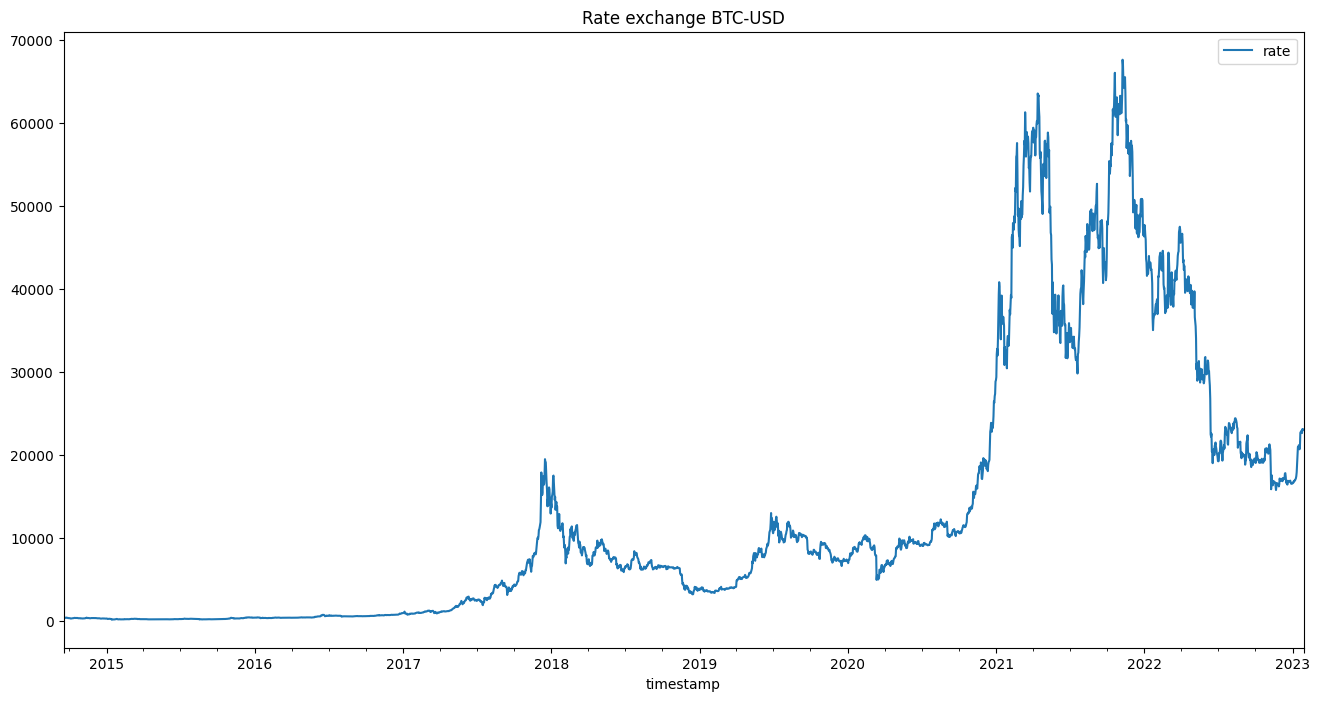

In [194]:
df_rate.plot(y='rate', use_index=True, figsize=(16,8), title='Rate exchange BTC-USD');

## Merging 2 dataframes : FNG index with rate change

In [192]:
df = fng_df.merge(df_rate, on='timestamp')
df

,value,value_classification,rate,volume
timestamp,,,,
2023-01-28,52.0,Neutral,23034.925781,19182090240
2023-01-27,55.0,Greed,23078.728516,25383335641
2023-01-26,54.0,Neutral,23032.777344,26357839322
2023-01-25,51.0,Neutral,23117.859375,30685366709
2023-01-24,52.0,Neutral,22636.468750,26405069715
...,...,...,...,...
2018-02-05,11.0,Extreme Fear,6955.270020,9285289984
2018-02-04,24.0,Extreme Fear,8277.009766,7073549824
2018-02-03,40.0,Fear,9174.910156,7263790080


In [193]:
df.rename(columns={'value': 'fng', 'value_classification': 'class'}, inplace=True)
df

,fng,class,rate,volume
timestamp,,,,
2023-01-28,52.0,Neutral,23034.925781,19182090240
2023-01-27,55.0,Greed,23078.728516,25383335641
2023-01-26,54.0,Neutral,23032.777344,26357839322
2023-01-25,51.0,Neutral,23117.859375,30685366709
2023-01-24,52.0,Neutral,22636.468750,26405069715
...,...,...,...,...
2018-02-05,11.0,Extreme Fear,6955.270020,9285289984
2018-02-04,24.0,Extreme Fear,8277.009766,7073549824
2018-02-03,40.0,Fear,9174.910156,7263790080
